In [ ]:
import torch as tch
import torchvision as tchvs
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import imageio as imio
from toolbox import disp


In [ ]:
device = 'cuda'

torch.Size([2433, 3612, 3])


(<Figure size 590.551x590.551 with 1 Axes>, array([[<Axes: >]], dtype=object))

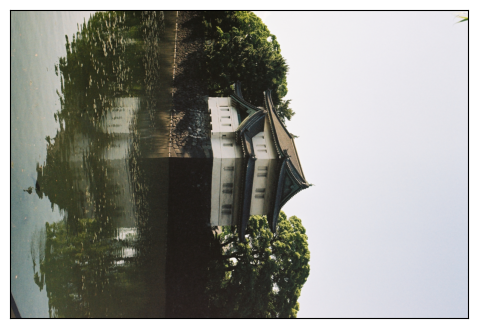

In [ ]:
img_2  = tch.tensor(imio.v2.imread('D061664-R1-10-13.JPG'))
img = Image.open('D061664-R1-10-13.JPG')
style = Image.open('style.JPG')
#test = Image.open('image_test.png')
img_height,img_width,img_depth = img_2.shape
print(img_2.shape)
disp(img_2,(1,1),3)


Premier Réseau de neurone
Ici on cherche à Extraire le contexte de l'image cible

Ici on ne recupere que la partie convolutionelle du réseau sans le classifieur

In [ ]:


def gram_matrix(tensor):
  _,depth, heigth, width = tensor.shape
  return tensor.view(depth, heigth*width).mm(tensor.view(depth, heigth*width).t())



class VGG(tch.nn.Module):
  def __init__(self):
    super(VGG, self).__init__()

    self.chosen_features = ['0', '5', '10', '19', '28']
    self.model = tchvs.models.vgg19(pretrained=True).features[:29]


  def forward(self, x):
    features = []

    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num in self.chosen_features):
        features.append(x)
    return features

model = VGG().to(device).eval()




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(tchvs.models.vgg19())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Ici on fait le pré processing des images car elle doivent avoir la taille

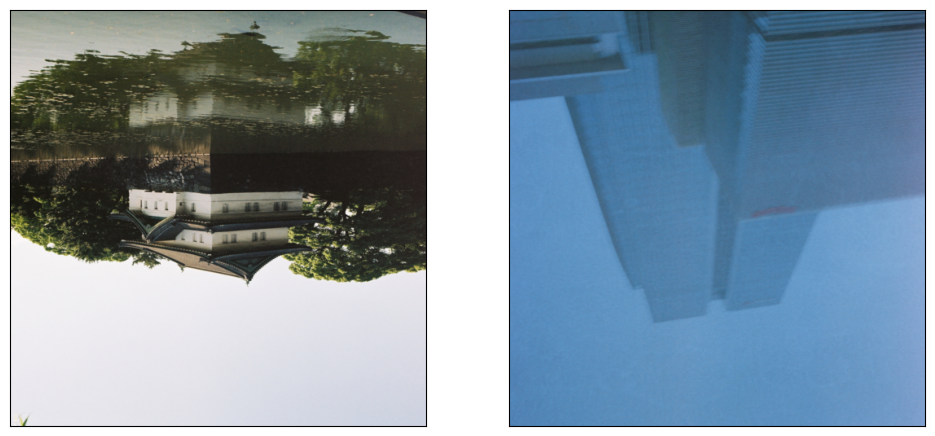

In [ ]:

img_size = 512
#on créer une fonction qui permet des faire en sorte que les images soient de même taille et normaliser
transform = tchvs.transforms.Compose([
    tchvs.transforms.Resize((img_size, img_size)),
    tchvs.transforms.ToTensor(),
    #tchvs.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #pas forcément nécessaire
])

input_image = transform(img)
style_image = transform(style)

input_image_vs = transform(img)
style_image_vs = transform(style)

input_image_vs = tch.transpose(input_image_vs,0,2)
style_image_vs = tch.transpose(style_image_vs,0,2)
disp([input_image_vs,style_image_vs],(1,2),3)

input_image = input_image.unsqueeze(0).to(device)
style_image = style_image.unsqueeze(0).to(device)

img_test = tch.randn(input_image.shape, requires_grad = True, device = device)

#img_test = input_image.clone().requires_grad_(True)

#img_test = style_image.clone().requires_grad_(True)

#image_test  = transform(test).unsqueeze(0).to(device)
#img_test = image_test.clone().requires_grad_(True)




Ici on va entrainer le reseaux pour qu'il puisse generer les images que l'on veut

In [ ]:
N_iter = 500
#lr = 1e-3
#content loss
alpha = 0
#style loss
beta = 1

content_layer_index = 19# Example, this could be 'conv4_2'
style_layer_indices = [0,5]

optimizer = tch.optim.LBFGS([img_test])
#loss = tch.nn.MSELoss(reduction = 'mean')


def closure():
  optimizer.zero_grad()
  test = model(img_test)
  style = model(style_image)
  content = model(input_image)

  content_loss = (1/2)*tch.mean((test[content_layer_index] -content[content_layer_index])**2)
  style_loss = 0


  for layer in style_layer_indices:
        _,c,h,w = test[layer].shape
        G = gram_matrix(test[layer])
        A = gram_matrix(style[layer])
        #print(style_loss)
        style_loss += (1/2)*tch.mean((G-A)**2)



  total_loss = alpha*content_loss + beta*style_loss

  total_loss.backward()
  return total_loss


for epoch in range(N_iter):
  optimizer.step(closure)
  if epoch % 100 == 0:
    print("epoch : ",epoch)
    print(closure())





tchvs.utils.save_image(img_test, "image_test_2.png")

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
N_iter = 50000
lr = 1e-3
#content loss
alpha = 1
#style loss
beta = 0

content_layer_index = 10
style_layer_indices = [0, 5, 10, 19, 28]

optimizer = tch.optim.Adam([img_test],lr =lr)
#loss = tch.nn.MSELoss(reduction = 'mean')
style_loss = 0

for epoch in range(N_iter):
  optimizer.zero_grad()
  test = model(img_test)
  style = model(style_image)
  content = model(input_image)

  content_loss = (1/2)*tch.mean((test[content_layer_index] -content[content_layer_index])**2)
  style_loss = 0


  for layer in style_layer_indices:
        G = gram_matrix(test[layer])
        A = gram_matrix(style[layer])
        style_loss += (1/2)*tch.mean((G-A)**2)



  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print("epoch : ",epoch)
    print(total_loss)

  if epoch% 10000 == 0:
    tchvs.utils.save_image(img_test,"image_test.png")


tchvs.utils.save_image(img_test, "image_test_final.png")


epoch :  0
tensor(3.1911, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  100
tensor(1.5487, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  200
tensor(1.1828, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  300
tensor(0.9565, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  400
tensor(0.7926, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  500
tensor(0.6795, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  600
tensor(0.5956, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  700
tensor(0.5315, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  800
tensor(0.4791, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  900
tensor(0.4353, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1000
tensor(0.3998, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1100
tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1200
tensor(0.3441, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1300
tensor(0.3217, device='cuda:0', grad_fn=<AddBackward0>)
epoch :  1400
tensor(0.3020, dev

KeyboardInterrupt: 